# CIFAR10 with CNNs
Simple starter notebook to benchmark your own CNN with PyTorch on the CIFAR-10 dataset.

OBS.:

- The main code is basically done, so focus on training the models and searching for the best hyperparameters and architectures.
- You are not required to use this exact code or even the PyTorch library.
- It is recommended to use execution environments with GPU access (such as Google Colab), since larger models will take more time to train.
- Remember to document the history of your experiments and which results motivated the changes in subsequent experiments.

In [ ]:
#@title Libs

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

from tqdm import tqdm

In [ ]:
#@title Dataset Setup

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 48.4MB/s]


### Defining the CNN model
Here we adapt the LeNet-5 architecture introduced in [*Gradient-based learning applied to document recognition*](https://ieeexplore.ieee.org/document/726791), originally developed to classify handwritten digits.

![lenet5](https://www.researchgate.net/publication/359784095/figure/fig2/AS:11431281079624737@1660789284522/Example-of-a-CNN-LeNet-5-14-is-able-to-identify-handwritten-digits-for-zip-code.png)


The main change we made here is the number of in/out channels, kernel sizes, padding, etc (enabling better results). It has 2 convolutional layers followed by 2 pooling (subsampling) layers. After the conv. blocks, we pass the feature maps through 2 hidden fully-connected layers to get the most activated neuron with the softmax function. If you want a more detailed explanation, [check this link](https://www.datasciencecentral.com/lenet-5-a-classic-cnn-architecture/) or reach us on Discord :)

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # Defining convolution blocks
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

    # Defining pooling layer
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Defining fully-connected layers
    self.fc_hidden1 = nn.Linear(64 * 8 * 8, 120)
    self.fc_hidden2 = nn.Linear(120, 84)
    self.fc_output = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(nn.ReLU()(self.conv1(x)))
    x = self.pool(nn.ReLU()(self.conv2(x)))
    x = x.view(x.size(0), -1) # flatten to input into fc layers
    x = nn.ReLU()(self.fc_hidden1(x))
    x = nn.ReLU()(self.fc_hidden2(x))
    x = self.fc_output(x)
    return x

In [ ]:
#@title Defining metrics helper

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [ ]:
#@title Hyperparameters

learning_rate = 0.001
num_epochs = 10
batch_size = 32

loss_function = nn.CrossEntropyLoss()

In [ ]:
#@title Loaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#@title Training loop

# Build the model
cnn = CNN()
cnn.cuda()

# Setting optimizer up
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# Early stopping setup
best_loss = float('inf')
patience = 5
patience_counter = 0

# Start training epochs loop
for epoch in tqdm(range(num_epochs)):
  epoch_loss = 0.0
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    # Forward pass
    optimizer.zero_grad()
    outputs = cnn(images)

    # Backward pass
    loss = loss_function(outputs, labels)
    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()

    if (i+1) % 1000 == 0:
      tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // batch_size}, Loss: {loss}')

  # Loss avrg
  epoch_loss /= len(train_loader)
  tqdm.write(f' Epoch {epoch+1} average loss: {epoch_loss:.4f}')

  # Early stopping using loss
  if epoch_loss < best_loss:
    best_loss = epoch_loss
    patience_counter = 0
  else:
    patience_counter += 1
    if patience_counter >= patience:
      tqdm.write("Early stopping triggered.")
      break

  0%|          | 0/10 [00:11<?, ?it/s]

 Epoch 1/10, Step 1000/1562, Loss: 1.3045551776885986


 10%|█         | 1/10 [00:17<02:34, 17.21s/it]

 Epoch 1 average loss: 1.3513


 10%|█         | 1/10 [00:27<02:34, 17.21s/it]

 Epoch 2/10, Step 1000/1562, Loss: 0.9413278698921204


 20%|██        | 2/10 [00:33<02:14, 16.82s/it]

 Epoch 2 average loss: 0.9563


 20%|██        | 2/10 [00:44<02:14, 16.82s/it]

 Epoch 3/10, Step 1000/1562, Loss: 0.4517377018928528


 30%|███       | 3/10 [00:49<01:54, 16.39s/it]

 Epoch 3 average loss: 0.7888


 30%|███       | 3/10 [01:00<01:54, 16.39s/it]

 Epoch 4/10, Step 1000/1562, Loss: 1.020493507385254


 40%|████      | 4/10 [01:05<01:37, 16.22s/it]

 Epoch 4 average loss: 0.6636


 40%|████      | 4/10 [01:15<01:37, 16.22s/it]

 Epoch 5/10, Step 1000/1562, Loss: 0.3785927891731262


 50%|█████     | 5/10 [01:21<01:21, 16.24s/it]

 Epoch 5 average loss: 0.5615


 50%|█████     | 5/10 [01:32<01:21, 16.24s/it]

 Epoch 6/10, Step 1000/1562, Loss: 0.3583453297615051


 60%|██████    | 6/10 [01:38<01:05, 16.33s/it]

 Epoch 6 average loss: 0.4670


 60%|██████    | 6/10 [01:48<01:05, 16.33s/it]

 Epoch 7/10, Step 1000/1562, Loss: 0.4040728211402893


 70%|███████   | 7/10 [01:54<00:48, 16.16s/it]

 Epoch 7 average loss: 0.3850


 70%|███████   | 7/10 [02:04<00:48, 16.16s/it]

 Epoch 8/10, Step 1000/1562, Loss: 0.15541107952594757


 80%|████████  | 8/10 [02:10<00:32, 16.09s/it]

 Epoch 8 average loss: 0.3135


 80%|████████  | 8/10 [02:20<00:32, 16.09s/it]

 Epoch 9/10, Step 1000/1562, Loss: 0.32187366485595703


 90%|█████████ | 9/10 [02:25<00:15, 15.96s/it]

 Epoch 9 average loss: 0.2598


 90%|█████████ | 9/10 [02:35<00:15, 15.96s/it]

 Epoch 10/10, Step 1000/1562, Loss: 0.09052383154630661


100%|██████████| 10/10 [02:41<00:00, 16.14s/it]

 Epoch 10 average loss: 0.2124


In [ ]:
#@title Evaluate model (accuracy, precision, recall, etc)

cnn.eval()
predictions = []
labels = []
for images, label in test_loader:
  images = images.cuda()
  label = label.cuda()

  output = cnn(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.7037, 'balanced_accuracy': np.float64(0.7036999999999999), 'precision': 0.7126224009353258, 'recall': 0.7037, 'f1_score': 0.7053980487538112}


# You can change/optimize this as you want
- Automatic hyperparameters optimization (Optuna)
- Regularization techniques (tip: try dropout)
- Use other convolution combinations (e.g. ResNet blocks)
- Validation set to track metrics during epochs
- Transform input data
- ...

## Imports

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from tqdm import tqdm

## Data augmentation + normalização

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),      # recorte aleatório com padding
    transforms.RandomHorizontalFlip(),         # espelhamento horizontal
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3),
])

# Carregando CIFAR-10
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:05<00:00, 29.3MB/s]


### A data augmentation (crop + flip) ajuda a rede a generalizar melhor, criando variantes artificiais das imagens de treino.

## Definição do modelo base (LeNet‑like)

In [ ]:
class CNNBase(nn.Module):
    def __init__(self, dropout_p=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # saída 32×32×32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # saída 64×32×32
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)       # reduz pela metade
        self.drop  = nn.Dropout(dropout_p)                       # dropout
        self.fc1   = nn.Linear(64*8*8, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.drop(torch.relu(self.fc1(x)))
        x = self.drop(torch.relu(self.fc2(x)))
        return self.fc3(x)

# Instanciando e mudando para GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNBase(dropout_p=0.0).to(device)

### Esse modelo usa kernel_size=3 e padding=1 para manter dimensões após convolução, seguido de pooling 2×2.

## Funções de treino, validação e métricas

### Objetivo: criar funções reutilizáveis para treinar e avaliar o modelo, registrando loss e métricas.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # learning_rate inicial

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def eval_model(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            trues.extend(labels.cpu().numpy())
    return trues, preds

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

## Experimento 1: baseline sem alterações

### Objetivo: treinar por algumas épocas e anotar as métricas iniciais.

In [ ]:
num_epochs = 10
history = {"train_loss": [], "test_acc": []}

for epoch in range(num_epochs):
    loss = train_epoch(model, train_loader, optimizer, criterion)
    trues, preds = eval_model(model, test_loader)
    scores = get_scores(trues, preds)
    history["train_loss"].append(loss)
    history["test_acc"].append(scores["accuracy"])
    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {loss:.4f} — Test Acc: {scores['accuracy']:.4f}")

print("Métricas finais:", scores)

Epoch 1/10 — Loss: 1.5370 — Test Acc: 0.5606
Epoch 2/10 — Loss: 1.1868 — Test Acc: 0.6512
Epoch 3/10 — Loss: 1.0425 — Test Acc: 0.6649
Epoch 4/10 — Loss: 0.9616 — Test Acc: 0.6919
Epoch 5/10 — Loss: 0.9061 — Test Acc: 0.7145
Epoch 6/10 — Loss: 0.8648 — Test Acc: 0.7196
Epoch 7/10 — Loss: 0.8345 — Test Acc: 0.7372
Epoch 8/10 — Loss: 0.8114 — Test Acc: 0.7380
Epoch 9/10 — Loss: 0.7871 — Test Acc: 0.7486
Epoch 10/10 — Loss: 0.7655 — Test Acc: 0.7441
Métricas finais: {'accuracy': 0.7441, 'precision': 0.7527900844853129, 'recall': 0.7441, 'f1_score': 0.7458841607312076}


### Anote no relatório gráfico de train_loss e test_acc por época e discuta se há under‑ ou overfitting.

## Experimento 2: variando tamanho do kernel

### Objetivo: alterar kernel_size para 5×5 em conv1 e conv2 e comparar resultados.

In [ ]:
class CNN_K5(nn.Module):
    def __init__(self, dropout_p=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool  = nn.MaxPool2d(2,2)
        self.drop  = nn.Dropout(dropout_p)
        self.fc1   = nn.Linear(64*8*8, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.drop(torch.relu(self.fc1(x)))
        x = self.drop(torch.relu(self.fc2(x)))
        return self.fc3(x)

# Re-instanciar modelo, otimizador e treinar novamente...
model = CNN_K5(dropout_p=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Filtros maiores capturam padrões mais globais, mas custam mais computação e podem suavizar detalhes finos.

In [ ]:
num_epochs = 10
history = {"train_loss": [], "test_acc": []}

for epoch in range(num_epochs):
    loss = train_epoch(model, train_loader, optimizer, criterion)
    trues, preds = eval_model(model, test_loader)
    scores = get_scores(trues, preds)
    history["train_loss"].append(loss)
    history["test_acc"].append(scores["accuracy"])
    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {loss:.4f} — Test Acc: {scores['accuracy']:.4f}")

print("Métricas finais:", scores)

Epoch 1/10 — Loss: 1.5929 — Test Acc: 0.5283
Epoch 2/10 — Loss: 1.2589 — Test Acc: 0.6156
Epoch 3/10 — Loss: 1.1200 — Test Acc: 0.6274
Epoch 4/10 — Loss: 1.0325 — Test Acc: 0.6824
Epoch 5/10 — Loss: 0.9674 — Test Acc: 0.6941
Epoch 6/10 — Loss: 0.9353 — Test Acc: 0.7147
Epoch 7/10 — Loss: 0.9022 — Test Acc: 0.7067
Epoch 8/10 — Loss: 0.8719 — Test Acc: 0.7120
Epoch 9/10 — Loss: 0.8461 — Test Acc: 0.7199
Epoch 10/10 — Loss: 0.8324 — Test Acc: 0.7364
Métricas finais: {'accuracy': 0.7364, 'precision': 0.7390055599678893, 'recall': 0.7364, 'f1_score': 0.7346928846081736}


## Experimento 3: adicionando Dropout

### Objetivo: testar dropout_p=0.3 para reduzir over‑fitting.

In [ ]:
model = CNNBase(dropout_p=0.3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
history = {"train_loss": [], "test_acc": []}

for epoch in range(num_epochs):
    loss = train_epoch(model, train_loader, optimizer, criterion)
    trues, preds = eval_model(model, test_loader)
    scores = get_scores(trues, preds)
    history["train_loss"].append(loss)
    history["test_acc"].append(scores["accuracy"])
    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {loss:.4f} — Test Acc: {scores['accuracy']:.4f}")

print("Métricas finais:", scores)

Epoch 1/10 — Loss: 1.7003 — Test Acc: 0.5171
Epoch 2/10 — Loss: 1.4155 — Test Acc: 0.5707
Epoch 3/10 — Loss: 1.2803 — Test Acc: 0.6237
Epoch 4/10 — Loss: 1.1930 — Test Acc: 0.6556
Epoch 5/10 — Loss: 1.1402 — Test Acc: 0.6648
Epoch 6/10 — Loss: 1.0997 — Test Acc: 0.6685
Epoch 7/10 — Loss: 1.0684 — Test Acc: 0.6929
Epoch 8/10 — Loss: 1.0487 — Test Acc: 0.7049
Epoch 9/10 — Loss: 1.0300 — Test Acc: 0.7094
Epoch 10/10 — Loss: 1.0129 — Test Acc: 0.7118
Métricas finais: {'accuracy': 0.7118, 'precision': 0.7151146023114485, 'recall': 0.7118, 'f1_score': 0.709075263961915}


## Experimento 4: ajustando learning rate

### Objetivo: testar lr=0.01 e lr=0.0001, compreender sensibilidade.

In [ ]:
for lr in [0.01, 0.001, 0.0001]:
    print(f"\n>>> Treinando com lr = {lr}")
    model = CNNBase(dropout_p=0.0).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(5):  # 5 épocas cada
        loss = train_epoch(model, train_loader, optimizer, criterion)
    trues, preds = eval_model(model, test_loader)
    print("Acc:", get_scores(trues,preds)["accuracy"])


>>> Treinando com lr = 0.01
Acc: 0.3877

>>> Treinando com lr = 0.001
Acc: 0.6789

>>> Treinando com lr = 0.0001
Acc: 0.5631


### Learning rate muito grande pula mínimos; muito pequeno demora demais.

## Comentários

### Experimento 1 (baseline: kernels 3×3, sem dropout, lr=1e‑3)


Evolução da loss e acc:
* Loss cai de 1.537 → 0.765 em 10 épocas.
* Test Accuracy cresce de 56% → 74,4%.

Métricas finais:
* Accuracy: 74,41%
* Precision: 75,28%
* Recall: 74,41%
* F1‑score: 74,59%

A curva suave de loss e a evolução consistente da acc indicam que o modelo está aprendendo sem grande overfitting (gap razoável entre train e test). Serve de boa linha de base.





### Experimento 2 (kernel_size=5×5, sem dropout, lr=1e‑3)

Evolução: loss inicia maior (1.59) e cai para 0.83; acc final 73,64%.

Métricas finais:
* Accuracy: 73,64% (–0,77 p.p. vs baseline)
* Precision: 73,90%
* Recall: 73,64%
* F1‑score: 73,47%

Filtros 5×5 capturam receptivos maiores, mas nossa base CIFAR é bem variada; a leve queda de desempenho sugere que o ganho de contexto não compensou a maior suavização de detalhes finos e o aumento de parâmetros.

## Experimento 3 (baseline + Dropout p=0.3, lr=1e‑3, kernel_size=5×5)

Evolução: começamos com loss bem alta (1.70) e acc baixa (51,7%), terminando em loss≈1.01 e acc≈71,2%.

Métricas finais
* Accuracy: 71,18% (–3,23 p.p. vs baseline)
* Precision: 71,51%
* Recall: 71,18%
* F1‑score: 70,91%

O dropout introduziu forte regularização, reduzindo overfitting mas também a capacidade de memorizar padrões. A convergência ficou mais lenta (mais épocas seriam necessárias para alcançar sinal similar ao baseline), mas com potencial para generalizar melhor em execuções mais longas ou com menos dados ruidosos.

## Experimento 4 (tuning de learning rate)

| learning\_rate | Test Accuracy |
| -------------: | ------------: |
|       **0.01** |        38,77% |
|      **0.001** |        67,89% |
|     **0.0001** |        56,31% |

* lr = 0.01: valor alto demais faz o otimizador “pular” mínimos, resultando em quase aleatoriedade (∼38% no CIFAR‑10).

* lr = 0.001: nosso valor padrão, encontra bom trade‑off entre convergência rápida e estabilidade.

* lr = 0.0001: muito pequeno; treina de forma estável, mas converge devagar, ficando preso em regiões de perda relativamente alta.


## Comparativo Geral

Melhor resultado bruto: Experimento 1 (74,4% de acc).

Impacto do kernel 5×5: pequena perda de ~0,8 p.p., mostra que nem sempre filtros maiores ajudam.

Efeito do dropout: regularização forte reduziu a acc inicial, mas pode prevenir overfitting em treinamento mais longo ou redes maiores.

Sensibilidade ao LR: o hiper‑parâmetro mais crítico — excesso e escassez de passo quebram a aprendizagem.


# Bloco de experimentos mais robustos

## Experimento 5: combinação de ajustes + split train/val + early stopping

### Objetivos:

Usar kernel 3×3, dropout p=0.15 e lr=1e‑3

Dividir 90% train / 10% val para monitorar over‑/under‑fitting

Early stopping no val loss

Só avaliar o test set após escolher o melhor modelo via validação

In [ ]:
from torch.utils.data import random_split
from sklearn import metrics

n_total = len(train_dataset)
n_val   = int(0.1 * n_total)
n_train = n_total - n_val

train_sub, val_sub = random_split(train_dataset, [n_train, n_val])

train_loader = torch.utils.data.DataLoader(train_sub, batch_size=32, shuffle=True, num_workers=2)
val_loader   = torch.utils.data.DataLoader(val_sub,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

def get_scores(trues, preds):
    return {
        "accuracy": metrics.accuracy_score(trues, preds),
        "precision": metrics.precision_score(trues, preds, average="weighted"),
        "recall": metrics.recall_score(trues, preds, average="weighted"),
        "f1_score": metrics.f1_score(trues, preds, average="weighted")
    }

In [ ]:
model = CNNBase(dropout_p=0.15).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
crit  = nn.CrossEntropyLoss()

best_val_loss = float('inf')
patience, counter = 5, 0
history = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[],
           "train_prec":[],"val_prec":[],"train_rec":[],"val_rec":[],
           "train_f1":[],"val_f1":[]}

for epoch in range(30):
    # — treino
    model.train()
    running_loss = 0.0
    all_t, all_p = [], []
    for imgs, lbls in train_loader:
        imgs,lbls = imgs.to(device), lbls.to(device)
        opt.zero_grad()
        out = model(imgs)
        loss = crit(out,lbls)
        loss.backward(); opt.step()
        running_loss += loss.item()*imgs.size(0)
        preds = out.argmax(1)
        all_t.extend(lbls.cpu().numpy()); all_p.extend(preds.cpu().numpy())
    train_loss = running_loss/len(train_sub)
    train_scores = get_scores(all_t, all_p)

    # — validação
    model.eval()
    running_loss = 0.0
    all_t, all_p = [], []
    with torch.no_grad():
        for imgs,lbls in val_loader:
            imgs,lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            loss = crit(out,lbls)
            running_loss += loss.item()*imgs.size(0)
            preds = out.argmax(1)
            all_t.extend(lbls.cpu().numpy()); all_p.extend(preds.cpu().numpy())
    val_loss = running_loss/len(val_sub)
    val_scores = get_scores(all_t, all_p)

    # — salvar histórico
    history["train_loss"].append(train_loss); history["val_loss"].append(val_loss)
    history["train_acc"].append(train_scores["accuracy"]); history["val_acc"].append(val_scores["accuracy"])
    history["train_prec"].append(train_scores["precision"]); history["val_prec"].append(val_scores["precision"])
    history["train_rec"].append(train_scores["recall"]); history["val_rec"].append(val_scores["recall"])
    history["train_f1"].append(train_scores["f1_score"]); history["val_f1"].append(val_scores["f1_score"])

    print(f"Ep{epoch+1}: "
          f"tr_loss={train_loss:.3f}, val_loss={val_loss:.3f} — "
          f"tr_acc={train_scores['accuracy']:.3f}, val_acc={val_scores['accuracy']:.3f}")

    # — early stopping via val_loss
    if val_loss < best_val_loss:
        best_val_loss, counter = val_loss, 0
        torch.save(model.state_dict(), 'best_combined.pth')
    else:
        counter += 1
        if counter >= patience:
            print("⏸️ Early stopping!")
            break


Ep1: tr_loss=1.632, val_loss=1.362 — tr_acc=0.398, val_acc=0.499
Ep2: tr_loss=1.339, val_loss=1.152 — tr_acc=0.515, val_acc=0.588
Ep3: tr_loss=1.195, val_loss=1.048 — tr_acc=0.574, val_acc=0.626
Ep4: tr_loss=1.108, val_loss=1.020 — tr_acc=0.607, val_acc=0.641
Ep5: tr_loss=1.056, val_loss=0.958 — tr_acc=0.627, val_acc=0.657
Ep6: tr_loss=1.016, val_loss=0.973 — tr_acc=0.644, val_acc=0.661
Ep7: tr_loss=0.992, val_loss=0.894 — tr_acc=0.652, val_acc=0.679
Ep8: tr_loss=0.968, val_loss=0.908 — tr_acc=0.660, val_acc=0.681
Ep9: tr_loss=0.942, val_loss=0.839 — tr_acc=0.670, val_acc=0.701
Ep10: tr_loss=0.926, val_loss=0.845 — tr_acc=0.675, val_acc=0.696
Ep11: tr_loss=0.904, val_loss=0.837 — tr_acc=0.682, val_acc=0.706
Ep12: tr_loss=0.884, val_loss=0.802 — tr_acc=0.692, val_acc=0.714
Ep13: tr_loss=0.880, val_loss=0.808 — tr_acc=0.694, val_acc=0.715
Ep14: tr_loss=0.863, val_loss=0.795 — tr_acc=0.698, val_acc=0.719
Ep15: tr_loss=0.852, val_loss=0.791 — tr_acc=0.704, val_acc=0.723
Ep16: tr_loss=0.845

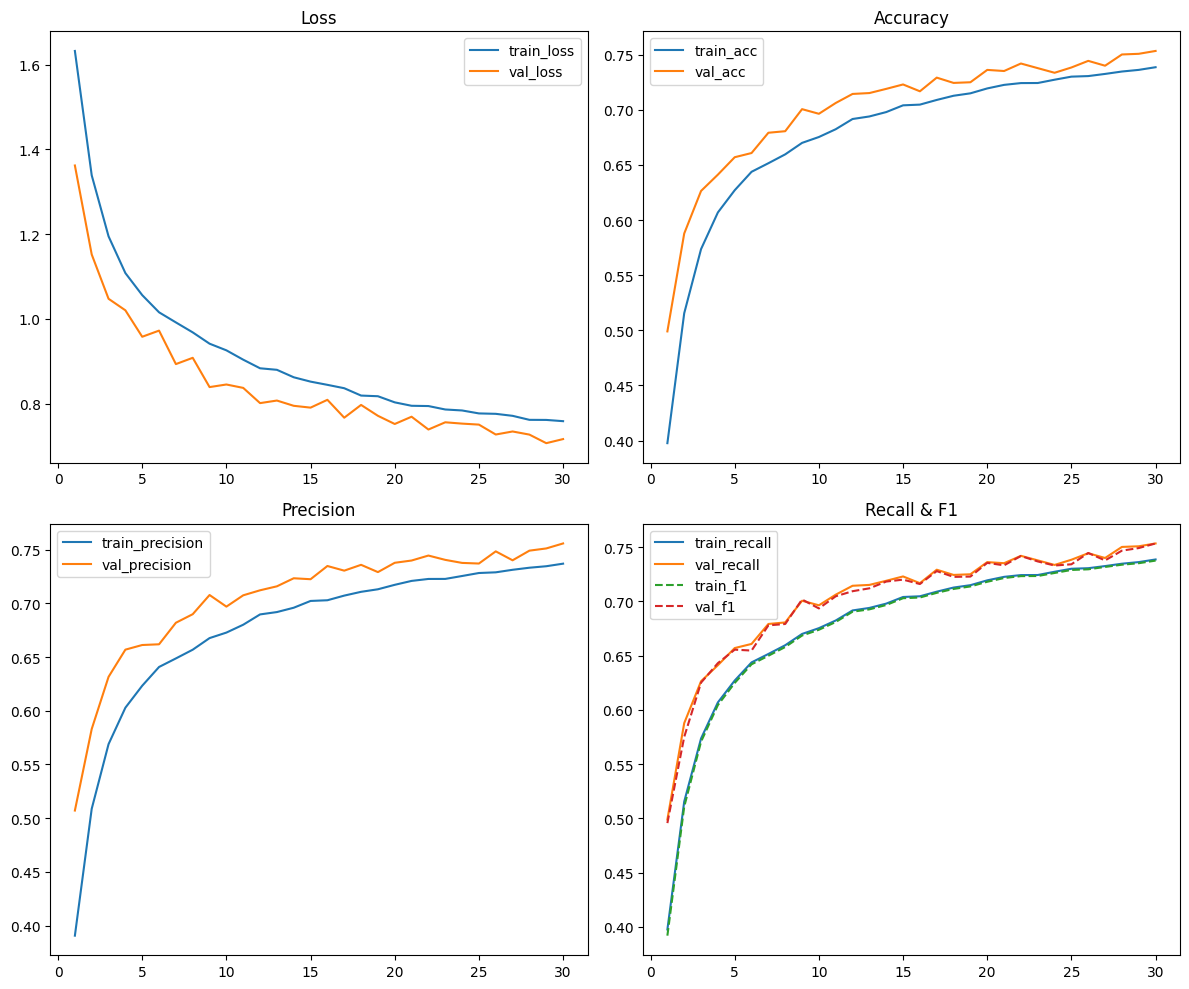

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"])+1)

fig, axes = plt.subplots(2, 2, figsize=(12,10))

# Loss
axes[0,0].plot(epochs, history["train_loss"], label="train_loss")
axes[0,0].plot(epochs, history["val_loss"],   label="val_loss")
axes[0,0].set_title("Loss")
axes[0,0].legend()

# Accuracy
axes[0,1].plot(epochs, history["train_acc"], label="train_acc")
axes[0,1].plot(epochs, history["val_acc"],   label="val_acc")
axes[0,1].set_title("Accuracy")
axes[0,1].legend()

# Precision
axes[1,0].plot(epochs, history["train_prec"], label="train_precision")
axes[1,0].plot(epochs, history["val_prec"],   label="val_precision")
axes[1,0].set_title("Precision")
axes[1,0].legend()

# Recall / F1
axes[1,1].plot(epochs, history["train_rec"], label="train_recall")
axes[1,1].plot(epochs, history["val_rec"],   label="val_recall")
axes[1,1].plot(epochs, history["train_f1"],  '--', label="train_f1")
axes[1,1].plot(epochs, history["val_f1"],    '--', label="val_f1")
axes[1,1].set_title("Recall & F1")
axes[1,1].legend()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from IPython.display import display

final_train_metrics = {
    "Loss": history["train_loss"][-1],
    "Accuracy": history["train_acc"][-1],
    "Precision": history["train_prec"][-1],
    "Recall": history["train_rec"][-1],
    "F1-score": history["train_f1"][-1],
}

final_val_metrics = {
    "Loss": history["val_loss"][-1],
    "Accuracy": history["val_acc"][-1],
    "Precision": history["val_prec"][-1],
    "Recall": history["val_rec"][-1],
    "F1-score": history["val_f1"][-1],
}

df = pd.DataFrame([final_train_metrics, final_val_metrics], index=["Train", "Validation"])
df = df.round(4)

display(df)


,Loss,Accuracy,Precision,Recall,F1-score
Train,0.7590,0.7386,0.7369,0.7386,0.7376
Validation,0.7167,0.7534,0.7557,0.7534,0.7534


In [ ]:
model = CNNBase(dropout_p=0.15).to(device)
model.load_state_dict(torch.load('best_combined.pth'))
model.eval()

all_t, all_p = [], []
with torch.no_grad():
    for imgs,lbls in test_loader:
        imgs,lbls = imgs.to(device), lbls.to(device)
        preds = model(imgs).argmax(1)
        all_t.extend(lbls.cpu().numpy()); all_p.extend(preds.cpu().numpy())

test_scores = get_scores(all_t, all_p)
print("✅ Métricas no test set:", test_scores)


✅ Métricas no test set: {'accuracy': 0.7662, 'precision': 0.7670919627529408, 'recall': 0.7662, 'f1_score': 0.764883778561941}


## Experimento 6: HPO automática com Optuna (com validação interna)

Objetivos

Otimizar por 20 trials: lr, dropout_p, batch_size, kernel_size

Cada trial é avaliado em val set (não test)

No fim, re-treinar o modelo com melhores hiper‑parâmetros e avaliar no test set

In [ ]:
!pip install optuna

import optuna

def build_model(trial):
    k = trial.suggest_categorical("kernel", [3,5])
    d = trial.suggest_float("dropout", 0.0, 0.4)
    return CNN_K5(dropout_p=d) if k==5 else CNNBase(dropout_p=d)

def objective(trial):
    # hiperpars
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    bs = trial.suggest_categorical("bs", [32,64])

    # DataLoaders dinâmicos
    tl = torch.utils.data.DataLoader(train_sub, batch_size=bs, shuffle=True)
    vl = torch.utils.data.DataLoader(val_sub,   batch_size=bs, shuffle=False)

    model = build_model(trial).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    crit  = nn.CrossEntropyLoss()

    # treino rápido
    for _ in range(5):
        model.train()
        for imgs,lbls in tl:
            imgs,lbls = imgs.to(device), lbls.to(device)
            opt.zero_grad()
            opt.step()

    # avaliação no val set
    all_t, all_p = [], []
    model.eval()
    with torch.no_grad():
        for imgs,lbls in vl:
            imgs,lbls = imgs.to(device), lbls.to(device)
            preds = model(imgs).argmax(1)
            all_t.extend(lbls.cpu().numpy()); all_p.extend(preds.cpu().numpy())
    return metrics.accuracy_score(all_t, all_p)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("🏆 Best params:", study.best_trial.params)


[I 2025-06-15 22:48:21,845] A new study created in memory with name: no-name-e4fdeeaf-caab-4b43-9e9a-1e3b4a59e30b
<ipython-input-13-3218124243>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2025-06-15 22:49:50,606] Trial 0 finished with value: 0.0962 and parameters: {'lr': 0.00230174468346247, 'bs': 32, 'kernel': 5, 'dropout': 0.06129800263793275}. Best is trial 0 with value: 0.0962.
<ipython-input-13-3218124243>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2025-06-15 22:51:18,154] Trial 1 finished with value: 0.0962 and parameters: {'lr': 0.0002931314493248552

🏆 Best params: {'lr': 0.0009085686658641642, 'bs': 64, 'kernel': 3, 'dropout': 0.2772223757272956}


In [ ]:
from math import inf

# 1) Recuperar melhores hiperpars
best = study.best_trial.params
lr   = best["lr"]
bs   = best["bs"]
kernel = best.get("kernel", 3)      # nome pode variar; ajuste conforme seu study
dropout = best.get("dropout", 0.0)

# 2) Reconstruir modelo e loaders
model = (CNN_K5(dropout_p=dropout) if kernel==5 else CNNBase(dropout_p=dropout)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(train_sub, batch_size=bs, shuffle=True,  num_workers=2)
val_loader   = torch.utils.data.DataLoader(val_sub,   batch_size=bs, shuffle=False, num_workers=2)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=2)

best_val_loss = inf
patience, counter = 5, 0

# 4) Loop de retrain
for epoch in range(1, 21):
    model.train()
    running_train_loss = 0.0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * imgs.size(0)
    train_loss = running_train_loss / len(train_sub)

    # --- Validação ---
    model.eval()
    running_val_loss = 0.0
    all_t, all_p = [], []
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            loss = criterion(out, lbls)
            running_val_loss += loss.item() * imgs.size(0)
            preds = out.argmax(1)
            all_t.extend(lbls.cpu().numpy())
            all_p.extend(preds.cpu().numpy())
    val_loss = running_val_loss / len(val_sub)
    val_scores = get_scores(all_t, all_p)

    print(f"Ep{epoch:02d} — tr_loss={train_loss:.4f}  val_loss={val_loss:.4f}  "
          f"val_acc={val_scores['accuracy']:.4f}  "
          f"val_prec={val_scores['precision']:.4f}  "
          f"val_rec={val_scores['recall']:.4f}  "
          f"val_f1={val_scores['f1_score']:.4f}")

    # --- Early stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_optuna.pth')
    else:
        counter += 1
        if counter >= patience:
            print("⏸️ Early stopping acionado.")
            break

# 5) Avaliação final no Test Set
# Carregar melhor modelo salvo
model.load_state_dict(torch.load('best_optuna.pth'))
model.eval()

all_t, all_p = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds = model(imgs).argmax(1)
        all_t.extend(lbls.cpu().numpy())
        all_p.extend(preds.cpu().numpy())

test_scores = get_scores(all_t, all_p)
print("\n🎯 Métricas no Test Set:")
for k,v in test_scores.items():
    print(f"  {k:>8}: {v:.4f}")


Ep01 — tr_loss=1.7427  val_loss=1.4402  val_acc=0.4730  val_prec=0.4674  val_rec=0.4730  val_f1=0.4570
Ep02 — tr_loss=1.4472  val_loss=1.2447  val_acc=0.5438  val_prec=0.5370  val_rec=0.5438  val_f1=0.5302
Ep03 — tr_loss=1.3220  val_loss=1.1777  val_acc=0.5748  val_prec=0.5832  val_rec=0.5748  val_f1=0.5742
Ep04 — tr_loss=1.2332  val_loss=1.0812  val_acc=0.6054  val_prec=0.6117  val_rec=0.6054  val_f1=0.5982
Ep05 — tr_loss=1.1668  val_loss=1.0330  val_acc=0.6320  val_prec=0.6474  val_rec=0.6320  val_f1=0.6355
Ep06 — tr_loss=1.1142  val_loss=0.9714  val_acc=0.6536  val_prec=0.6549  val_rec=0.6536  val_f1=0.6520
Ep07 — tr_loss=1.0813  val_loss=0.9430  val_acc=0.6626  val_prec=0.6656  val_rec=0.6626  val_f1=0.6612
Ep08 — tr_loss=1.0449  val_loss=0.9322  val_acc=0.6746  val_prec=0.6736  val_rec=0.6746  val_f1=0.6703
Ep09 — tr_loss=1.0242  val_loss=0.9078  val_acc=0.6792  val_prec=0.6792  val_rec=0.6792  val_f1=0.6749
Ep10 — tr_loss=0.9934  val_loss=0.9170  val_acc=0.6758  val_prec=0.6796  

## Experimento 7: Transfer Learning com ResNet18

### Objetivos

Usar ResNet18 pré‑treinada adaptada para CIFAR‑10

Monitorar as 4 métricas no val set em cada época

Avaliar no test set ao final

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
import torchvision.models as models

resnet = models.resnet18(pretrained=True)
resnet.conv1 = nn.Conv2d(3,64, kernel_size=3, stride=1, padding=1, bias=False)
resnet.maxpool = nn.Identity()
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = resnet.to(device)

opt  = torch.optim.Adam(resnet.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

history_resnet = {
    "train_loss": [],   "val_loss": [],
    "train_accuracy": [], "val_accuracy": [],
    "train_precision": [], "val_precision": [],
    "train_recall": [],    "val_recall": [],
    "train_f1_score": [],  "val_f1_score": []
}

# Early stopping
best_val_loss = float('inf')
patience, counter = 5, 0


In [ ]:
for epoch in range(1, 16):
    # — Treino —
    resnet.train()
    running_tr_loss = 0.0
    tr_t, tr_p = [], []
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        opt.zero_grad()
        out = resnet(imgs)
        loss = crit(out, lbls)
        loss.backward()
        opt.step()
        running_tr_loss += loss.item() * imgs.size(0)
        preds = out.argmax(1)
        tr_t.extend(lbls.cpu().numpy()); tr_p.extend(preds.cpu().numpy())

    train_loss = running_tr_loss / len(train_sub)
    tr_scores  = get_scores(tr_t, tr_p)

    # — Validação —
    resnet.eval()
    running_val_loss = 0.0
    val_t, val_p = [], []
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = resnet(imgs)
            loss = crit(out, lbls)
            running_val_loss += loss.item() * imgs.size(0)
            preds = out.argmax(1)
            val_t.extend(lbls.cpu().numpy()); val_p.extend(preds.cpu().numpy())

    val_loss = running_val_loss / len(val_sub)
    val_scores = get_scores(val_t, val_p)

    # — Salvar no history_resnet —
    history_resnet["train_loss"].append(train_loss)
    history_resnet["val_loss"].append(val_loss)

    history_resnet["train_accuracy"].append(tr_scores["accuracy"])
    history_resnet["val_accuracy"].append(val_scores["accuracy"])

    history_resnet["train_precision"].append(tr_scores["precision"])
    history_resnet["val_precision"].append(val_scores["precision"])

    history_resnet["train_recall"].append(tr_scores["recall"])
    history_resnet["val_recall"].append(val_scores["recall"])

    history_resnet["train_f1_score"].append(tr_scores["f1_score"])
    history_resnet["val_f1_score"].append(val_scores["f1_score"])

    # — Logging —
    print(f"ResNet Ep{epoch:02d} — tr_loss={train_loss:.4f}  val_loss={val_loss:.4f}  "
          f"tr_acc={tr_scores['accuracy']:.4f}  val_acc={val_scores['accuracy']:.4f}")

    # — Early stopping no val_loss —
    if val_loss < best_val_loss:
        best_val_loss, counter = val_loss, 0
        torch.save(resnet.state_dict(), 'best_resnet.pth')
    else:
        counter += 1
        if counter >= patience:
            print("⏸️ Early stopping acionado.")
            break


ResNet Ep01 — tr_loss=0.6126  val_loss=0.5327  tr_acc=0.7942  val_acc=0.8190
ResNet Ep02 — tr_loss=0.5017  val_loss=0.4748  tr_acc=0.8284  val_acc=0.8388
ResNet Ep03 — tr_loss=0.4283  val_loss=0.4499  tr_acc=0.8557  val_acc=0.8474
ResNet Ep04 — tr_loss=0.3730  val_loss=0.3883  tr_acc=0.8733  val_acc=0.8656
ResNet Ep05 — tr_loss=0.3412  val_loss=0.3377  tr_acc=0.8844  val_acc=0.8846
ResNet Ep06 — tr_loss=0.3062  val_loss=0.3211  tr_acc=0.8959  val_acc=0.8870
ResNet Ep07 — tr_loss=0.2747  val_loss=0.3037  tr_acc=0.9069  val_acc=0.8984
ResNet Ep08 — tr_loss=0.2511  val_loss=0.3210  tr_acc=0.9154  val_acc=0.8918
ResNet Ep09 — tr_loss=0.2343  val_loss=0.3041  tr_acc=0.9195  val_acc=0.9004
ResNet Ep10 — tr_loss=0.2081  val_loss=0.2987  tr_acc=0.9280  val_acc=0.9094
ResNet Ep11 — tr_loss=0.1958  val_loss=0.2576  tr_acc=0.9323  val_acc=0.9142
ResNet Ep12 — tr_loss=0.1787  val_loss=0.2702  tr_acc=0.9387  val_acc=0.9098
ResNet Ep13 — tr_loss=0.1706  val_loss=0.2867  tr_acc=0.9419  val_acc=0.9112

In [ ]:
num_epochs = len(history_resnet["train_accuracy"])

print("Epoch | Train Loss | Train Acc | Train Prec | Train Rec | Train F1")
print("------+------------+-----------+------------+-----------+---------")
for epoch in range(num_epochs):
    ep = epoch + 1
    tl = history_resnet["train_loss"][epoch]
    ta = history_resnet["train_accuracy"][epoch]
    tp = history_resnet["train_precision"][epoch]
    tr = history_resnet["train_recall"][epoch]
    tf = history_resnet["train_f1_score"][epoch]
    print(f"{ep:5d} | {tl:10.4f} | {ta:9.4f} | {tp:10.4f} | {tr:9.4f} | {tf:7.4f}")


Epoch | Train Loss | Train Acc | Train Prec | Train Rec | Train F1
------+------------+-----------+------------+-----------+---------
    1 |     0.6126 |    0.7942 |     0.7938 |    0.7942 |  0.7939
    2 |     0.5017 |    0.8284 |     0.8281 |    0.8284 |  0.8282
    3 |     0.4283 |    0.8557 |     0.8555 |    0.8557 |  0.8556
    4 |     0.3730 |    0.8733 |     0.8731 |    0.8733 |  0.8731
    5 |     0.3412 |    0.8844 |     0.8844 |    0.8844 |  0.8844
    6 |     0.3062 |    0.8959 |     0.8958 |    0.8959 |  0.8958
    7 |     0.2747 |    0.9069 |     0.9067 |    0.9069 |  0.9068
    8 |     0.2511 |    0.9154 |     0.9153 |    0.9154 |  0.9153
    9 |     0.2343 |    0.9195 |     0.9195 |    0.9195 |  0.9195
   10 |     0.2081 |    0.9280 |     0.9280 |    0.9280 |  0.9280
   11 |     0.1958 |    0.9323 |     0.9322 |    0.9323 |  0.9323
   12 |     0.1787 |    0.9387 |     0.9386 |    0.9387 |  0.9386
   13 |     0.1706 |    0.9419 |     0.9419 |    0.9419 |  0.9419
   14 | 

In [ ]:
num_epochs = len(history_resnet["val_accuracy"])

print("Epoch |  Val Loss  | Val Acc  | Val Prec | Val Rec  | Val F1")
print("------+-----------+----------+----------+----------+---------")
for epoch in range(num_epochs):
    ep = epoch + 1
    vl = history_resnet["val_loss"][epoch]
    va = history_resnet["val_accuracy"][epoch]
    vp = history_resnet["val_precision"][epoch]
    vr = history_resnet["val_recall"][epoch]
    vf = history_resnet["val_f1_score"][epoch]
    print(f"{ep:5d} | {vl:9.4f} | {va:8.4f} | {vp:8.4f} | {vr:8.4f} | {vf:7.4f}")


Epoch |  Val Loss  | Val Acc  | Val Prec | Val Rec  | Val F1
------+-----------+----------+----------+----------+---------
    1 |    0.5327 |   0.8190 |   0.8270 |   0.8190 |  0.8153
    2 |    0.4748 |   0.8388 |   0.8432 |   0.8388 |  0.8389
    3 |    0.4499 |   0.8474 |   0.8536 |   0.8474 |  0.8461
    4 |    0.3883 |   0.8656 |   0.8722 |   0.8656 |  0.8631
    5 |    0.3377 |   0.8846 |   0.8870 |   0.8846 |  0.8838
    6 |    0.3211 |   0.8870 |   0.8905 |   0.8870 |  0.8877
    7 |    0.3037 |   0.8984 |   0.9005 |   0.8984 |  0.8985
    8 |    0.3210 |   0.8918 |   0.8978 |   0.8918 |  0.8924
    9 |    0.3041 |   0.9004 |   0.9062 |   0.9004 |  0.9015
   10 |    0.2987 |   0.9094 |   0.9098 |   0.9094 |  0.9087
   11 |    0.2576 |   0.9142 |   0.9163 |   0.9142 |  0.9144
   12 |    0.2702 |   0.9098 |   0.9099 |   0.9098 |  0.9096
   13 |    0.2867 |   0.9112 |   0.9147 |   0.9112 |  0.9118
   14 |    0.2669 |   0.9160 |   0.9165 |   0.9160 |  0.9156
   15 |    0.2525 |   0

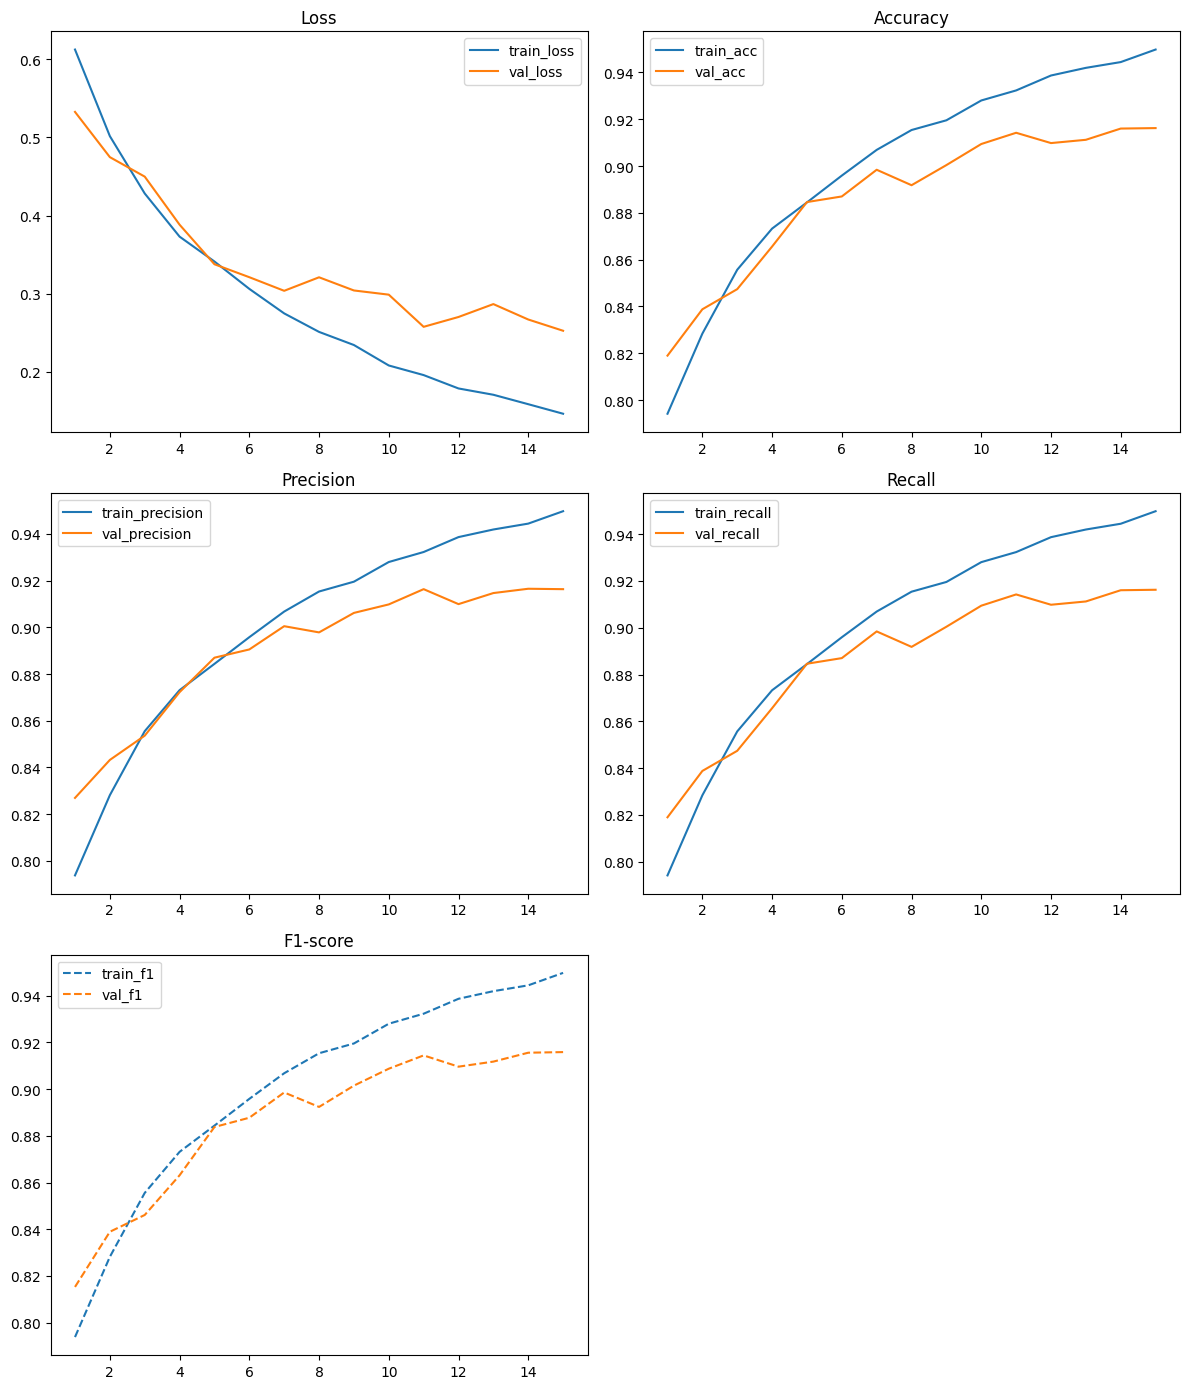

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_resnet["train_loss"])+1)
fig, axes = plt.subplots(3, 2, figsize=(12,14))

# Loss
axes[0,0].plot(epochs, history_resnet["train_loss"], label="train_loss")
axes[0,0].plot(epochs, history_resnet["val_loss"],   label="val_loss")
axes[0,0].set_title("Loss"); axes[0,0].legend()

# Accuracy
axes[0,1].plot(epochs, history_resnet["train_accuracy"], label="train_acc")
axes[0,1].plot(epochs, history_resnet["val_accuracy"],   label="val_acc")
axes[0,1].set_title("Accuracy"); axes[0,1].legend()

# Precision
axes[1,0].plot(epochs, history_resnet["train_precision"], label="train_precision")
axes[1,0].plot(epochs, history_resnet["val_precision"],   label="val_precision")
axes[1,0].set_title("Precision"); axes[1,0].legend()

# Recall
axes[1,1].plot(epochs, history_resnet["train_recall"], label="train_recall")
axes[1,1].plot(epochs, history_resnet["val_recall"],   label="val_recall")
axes[1,1].set_title("Recall"); axes[1,1].legend()

# F1‑score
axes[2,0].plot(epochs, history_resnet["train_f1_score"], '--', label="train_f1")
axes[2,0].plot(epochs, history_resnet["val_f1_score"],   '--', label="val_f1")
axes[2,0].set_title("F1-score"); axes[2,0].legend()

# painel vazio
axes[2,1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
all_t, all_p = [], []
resnet.eval()
with torch.no_grad():
    for imgs,lbls in test_loader:
        imgs,lbls = imgs.to(device), lbls.to(device)
        preds = resnet(imgs).argmax(1)
        all_t.extend(lbls.cpu().numpy()); all_p.extend(preds.cpu().numpy())
print("🔍 ResNet test scores:", get_scores(all_t, all_p))


🔍 ResNet test scores: {'accuracy': 0.917, 'precision': 0.9175424589859835, 'recall': 0.917, 'f1_score': 0.9168352013629341}
